# exp004
他のスマホの予測使える？

In [347]:
import os
import pandas as pd
import numpy as np
import ipynb_path
import simdkalman
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles
import seaborn as sns
from tqdm.notebook import tqdm

pd.set_option('display.max_rows', 500)

In [348]:
import plotly
import plotly.express as px
%matplotlib inline

In [349]:
def get_nb_name():
    nb_path = ipynb_path.get()
    nb_name = nb_path.rsplit('/',1)[1].replace('.ipynb','')
    return nb_name

In [350]:
def calc_haversine(lat1, lon1, lat2, lon2):
    """Calculates the great circle distance between two points
    on the earth. Inputs are array-like and specified in decimal degrees.
    """
    RADIUS = 6_367_000
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    dist = 2 * RADIUS * np.arcsin(a**0.5)
    return dist

In [351]:
def percentile50(x):
    return np.percentile(x, 50)
def percentile95(x):
    return np.percentile(x, 95)

In [352]:
def visualize_trafic(df, center, zoom=9):
    fig = px.scatter_mapbox(df,
                            
                            # Here, plotly gets, (x,y) coordinates
                            lat="latDeg",
                            lon="lngDeg",
                            
                            #Here, plotly detects color of series
                            color="phoneName",
                            labels="phoneName",
                            
                            zoom=zoom,
                            center=center,
                            height=600,
                            width=800)
    fig.update_layout(mapbox_style='stamen-terrain')
    fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
    fig.update_layout(title_text="GPS trafic")
    fig.show()
    
def one_collection_viz(df, collection):
    target_df = df[df['collectionName']==collection].copy()
    lat_center = target_df['latDeg'].mean()
    lng_center = target_df['lngDeg'].mean()
    center = {"lat":lat_center, "lon":lng_center}
    
    visualize_trafic(target_df, center)

In [353]:
# directory setting
nb_name = get_nb_name()
INPUT = '../input/google-smartphone-decimeter-challenge'
OUTPUT = '../output/' + nb_name
os.makedirs(OUTPUT, exist_ok=True)

In [354]:
base_train = pd.read_csv(INPUT + '/' + 'baseline_locations_train.csv')
base_test = pd.read_csv(INPUT + '/' + 'baseline_locations_test.csv')
sample_sub = pd.read_csv(INPUT + '/' + 'sample_submission.csv')
ground_truth_train = pd.read_csv(INPUT + '/prep/ground_truth_train.csv')

In [355]:
ground_truth_train['phone'] = ground_truth_train['collectionName'] + '_' + ground_truth_train['phoneName']

In [356]:
def add_distance_diff(df):
    df['latDeg_prev'] = df['latDeg'].shift(1)
    df['latDeg_next'] = df['latDeg'].shift(-1)
    df['lngDeg_prev'] = df['lngDeg'].shift(1)
    df['lngDeg_next'] = df['lngDeg'].shift(-1)
    df['phone_prev'] = df['phone'].shift(1)
    df['phone_next'] = df['phone'].shift(-1)
    
    df['dist_prev'] = calc_haversine(df['latDeg'], df['lngDeg'], df['latDeg_prev'], df['lngDeg_prev'])
    df['dist_next'] = calc_haversine(df['latDeg'], df['lngDeg'], df['latDeg_next'], df['lngDeg_next'])
    
    df.loc[df['phone']!=df['phone_prev'], ['latDeg_prev', 'lngDeg_prev', 'dist_prev']] = np.nan
    df.loc[df['phone']!=df['phone_next'], ['latDeg_next', 'lngDeg_next', 'dist_next']] = np.nan
    
    return df

In [357]:
base_train = add_distance_diff(base_train)
base_test = add_distance_diff(base_test)
ground_truth_train = add_distance_diff(ground_truth_train)

In [358]:
# 外れ値除去
th = 50
base_train.loc[((base_train['dist_prev'] > th) & (base_train['dist_next'] > th)), ['latDeg', 'lngDeg']] = np.nan
base_test.loc[((base_test['dist_prev'] > th) & (base_test['dist_next'] > th)), ['latDeg', 'lngDeg']] = np.nan

In [359]:
# カルマンスムーザー
T = 1.0
state_transition = np.array([[1, 0, T, 0, 0.5 * T ** 2, 0], [0, 1, 0, T, 0, 0.5 * T ** 2], [0, 0, 1, 0, T, 0],
                             [0, 0, 0, 1, 0, T], [0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 1]])
process_noise = np.diag([1e-5, 1e-5, 5e-6, 5e-6, 1e-6, 1e-6]) + np.ones((6, 6)) * 1e-9
observation_model = np.array([[1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0]])
observation_noise = np.diag([5e-5, 5e-5]) + np.ones((2, 2)) * 1e-9

kf = simdkalman.KalmanFilter(
        state_transition = state_transition,
        process_noise = process_noise,
        observation_model = observation_model,
        observation_noise = observation_noise)

def apply_kf_smoothing(df, kf_=kf):
    unique_paths = df[['collectionName', 'phoneName']].drop_duplicates().to_numpy()
    for collection, phone in unique_paths:
        cond = np.logical_and(df['collectionName'] == collection, df['phoneName'] == phone)
        data = df[cond][['latDeg', 'lngDeg']].to_numpy()
        data = data.reshape(1, len(data), 2)
        smoothed = kf_.smooth(data)
        df.loc[cond, 'latDeg'] = smoothed.states.mean[0, :, 0]
        df.loc[cond, 'lngDeg'] = smoothed.states.mean[0, :, 1]
    return df

In [360]:
cols = ['collectionName', 'phoneName', 'millisSinceGpsEpoch', 'latDeg', 'lngDeg']

In [361]:
df_basepreds_kf = apply_kf_smoothing(base_train[cols])

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [362]:
df_basepreds_kf

collectionName        phoneName  millisSinceGpsEpoch  \
0       2020-05-14-US-MTV-1           Pixel4        1273529463442   
1       2020-05-14-US-MTV-1           Pixel4        1273529464442   
2       2020-05-14-US-MTV-1           Pixel4        1273529465442   
3       2020-05-14-US-MTV-1           Pixel4        1273529466442   
4       2020-05-14-US-MTV-1           Pixel4        1273529467442   
...                     ...              ...                  ...   
131337  2021-04-29-US-SJC-2  SamsungS20Ultra        1303760315000   
131338  2021-04-29-US-SJC-2  SamsungS20Ultra        1303760316000   
131339  2021-04-29-US-SJC-2  SamsungS20Ultra        1303760317000   
131340  2021-04-29-US-SJC-2  SamsungS20Ultra        1303760318000   
131341  2021-04-29-US-SJC-2  SamsungS20Ultra        1303760319000   

                   latDeg              lngDeg  
0       37.42354944890939 -122.09400632509110  
1       37.42356446305371 -122.09406288016454  
2       37.42357293993798 -122.09409752012860  
3       37.42357784405586 -122.09411603838448  
4       37.42357891748019 -122.09412293367829  
...                   ...                 ...  
131337  37.33446607335141 -121.89959676269369  
131338  37.33447270635135 -121.89959191694244  
131339  37.33448095983902 -121.89958839172198  
131340  37.33448745911839 -121.89958182806456  
131341  37.33449265792927 -121.89957382052091  

[131342 rows x 5 columns]

## 線形補間

In [363]:
def make_lerp_data(df):
    '''
    同じcollectionの違うphoneの時刻に合わせたlat,lngの補間値を生成する
    '''
    org_columns = df.columns
    
    # 時刻 × collection × phoneの組み合わせを生成し、元データと結合（補間対象のレコードを生成）
    time_list = df[['collectionName', 'millisSinceGpsEpoch']].drop_duplicates()
    phone_list =df[['collectionName', 'phoneName']].drop_duplicates()
    tmp = time_list.merge(phone_list, on='collectionName', how='outer')
    
    lerp_df = tmp.merge(df, on=['collectionName', 'millisSinceGpsEpoch', 'phoneName'], how='left')
    lerp_df['phone'] = gt_lerp['collectionName'] + '_' + gt_lerp['phoneName']
    lerp_df = lerp_df.sort_values(['phone', 'millisSinceGpsEpoch'])
    
    # 線形補間
    lerp_df['latDeg_prev'] = lerp_df['latDeg'].shift(1)
    lerp_df['latDeg_next'] = lerp_df['latDeg'].shift(-1)
    lerp_df['lngDeg_prev'] = lerp_df['lngDeg'].shift(1)
    lerp_df['lngDeg_next'] = lerp_df['lngDeg'].shift(-1)
    lerp_df['phone_prev'] = lerp_df['phone'].shift(1)
    lerp_df['phone_next'] = lerp_df['phone'].shift(-1)
    lerp_df['time_prev'] = lerp_df['millisSinceGpsEpoch'].shift(1)
    lerp_df['time_next'] = lerp_df['millisSinceGpsEpoch'].shift(-1)

    lerp_df = lerp_df[(lerp_df['latDeg'].isnull())&(lerp_df['phone']==lerp_df['phone_prev'])&(lerp_df['phone']==lerp_df['phone_next'])].copy()
    
    lerp_df['latDeg'] = lerp_df['latDeg_prev'] + ((lerp_df['latDeg_next'] - lerp_df['latDeg_prev']) * ((lerp_df['millisSinceGpsEpoch'] - lerp_df['time_prev']) / (lerp_df['time_next'] - lerp_df['time_prev']))) 
    lerp_df['lngDeg'] = lerp_df['lngDeg_prev'] + ((lerp_df['lngDeg_next'] - lerp_df['lngDeg_prev']) * ((lerp_df['millisSinceGpsEpoch'] - lerp_df['time_prev']) / (lerp_df['time_next'] - lerp_df['time_prev']))) 
   
    lerp_df = lerp_df[~lerp_df['latDeg'].isnull()]
    
    return lerp_df[org_columns]

In [364]:
def calc_mean_pred(df, lerp_df):
    add_lerp = pd.concat([df, lerp_df])
    mean_pred_result = add_lerp.groupby(['collectionName', 'millisSinceGpsEpoch'])[['latDeg', 'lngDeg']].mean().reset_index()
    mean_pred_df = df[['collectionName', 'phoneName', 'millisSinceGpsEpoch']].copy()
    mean_pred_df = mean_pred_df.merge(mean_pred_result[['collectionName', 'millisSinceGpsEpoch', 'latDeg', 'lngDeg']], on=['collectionName', 'millisSinceGpsEpoch'], how='left')
    return mean_pred_df

In [365]:
train_lerp = make_lerp_data(df_basepreds_kf)

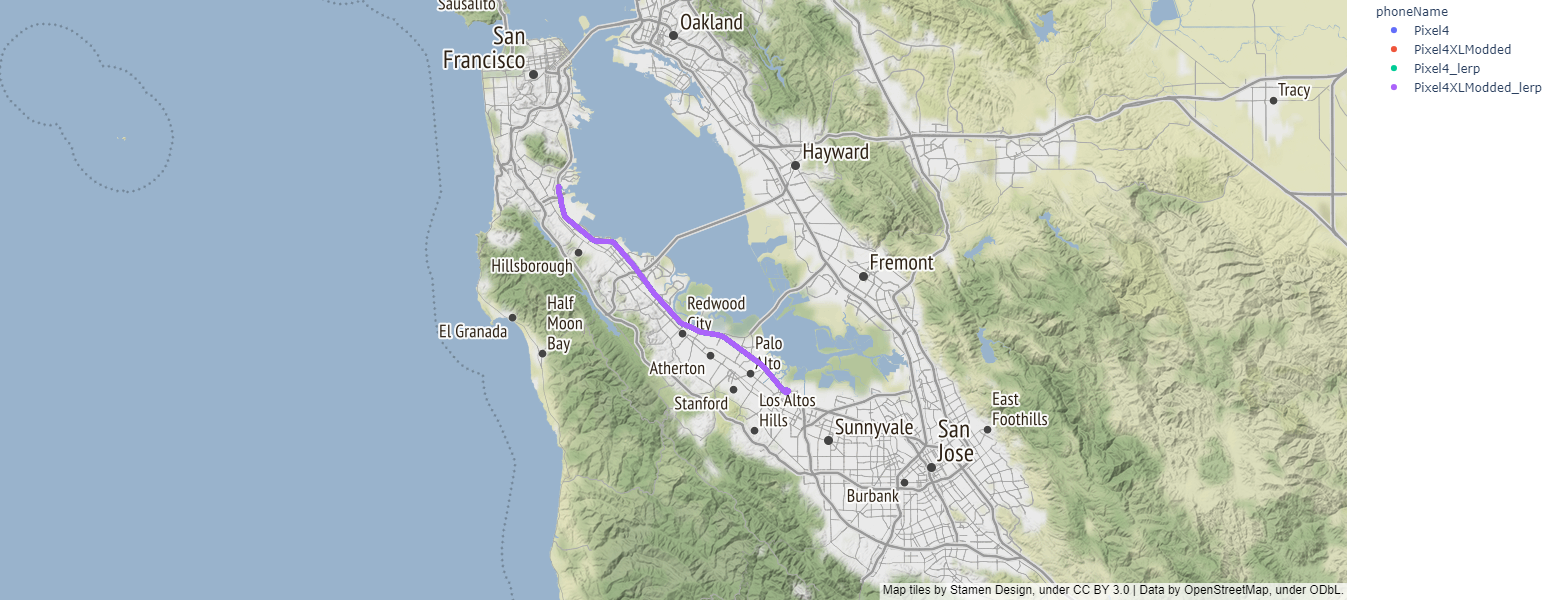

In [366]:
tmp1 = df_basepreds_kf.copy()
tmp2 = train_lerp.copy()
tmp2['phoneName'] = tmp2['phoneName'] + '_lerp'
tmp = pd.concat([tmp1, tmp2])
tmp = tmp.sort_values(['collectionName', 'millisSinceGpsEpoch']).reset_index(drop=True)
one_collection_viz(tmp, collections[0])

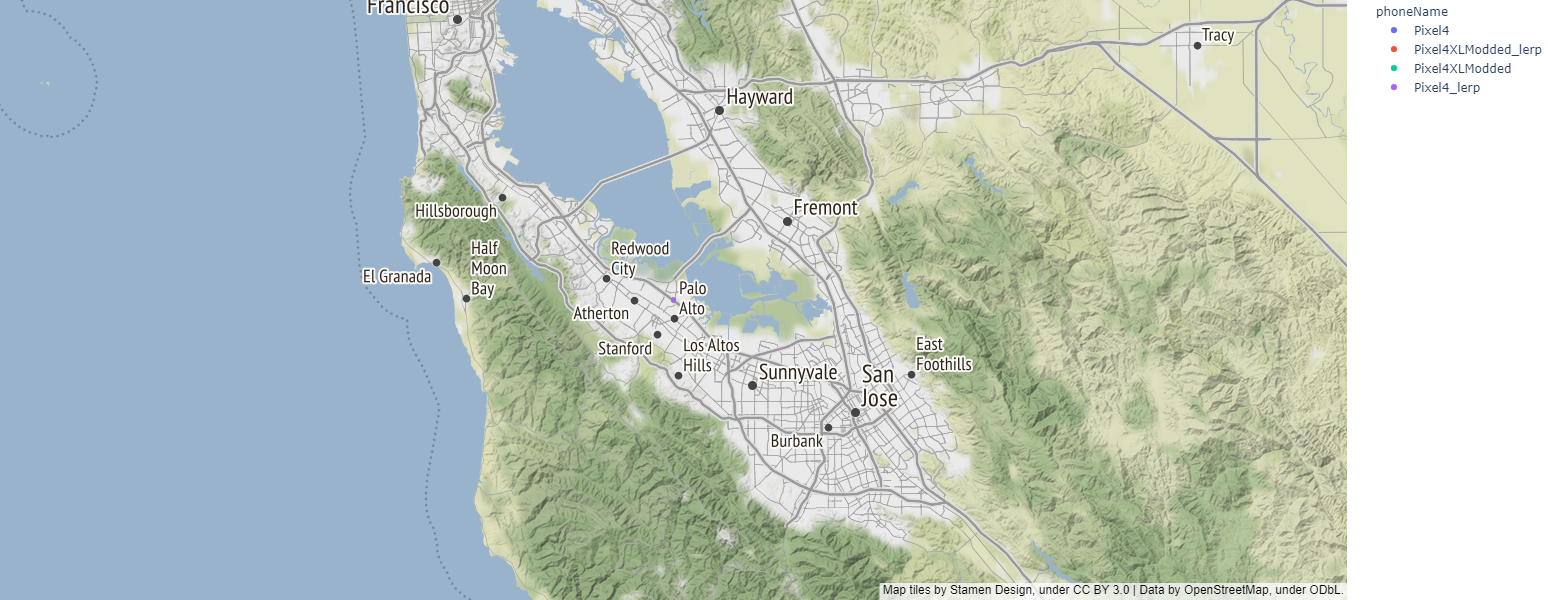

In [367]:
one_collection_viz(tmp[tmp['millisSinceGpsEpoch'].isin([1273529900442, 1273529900449])], collections[0])

In [368]:
train_mean_pred = calc_mean_pred(df_basepreds_kf, train_lerp)

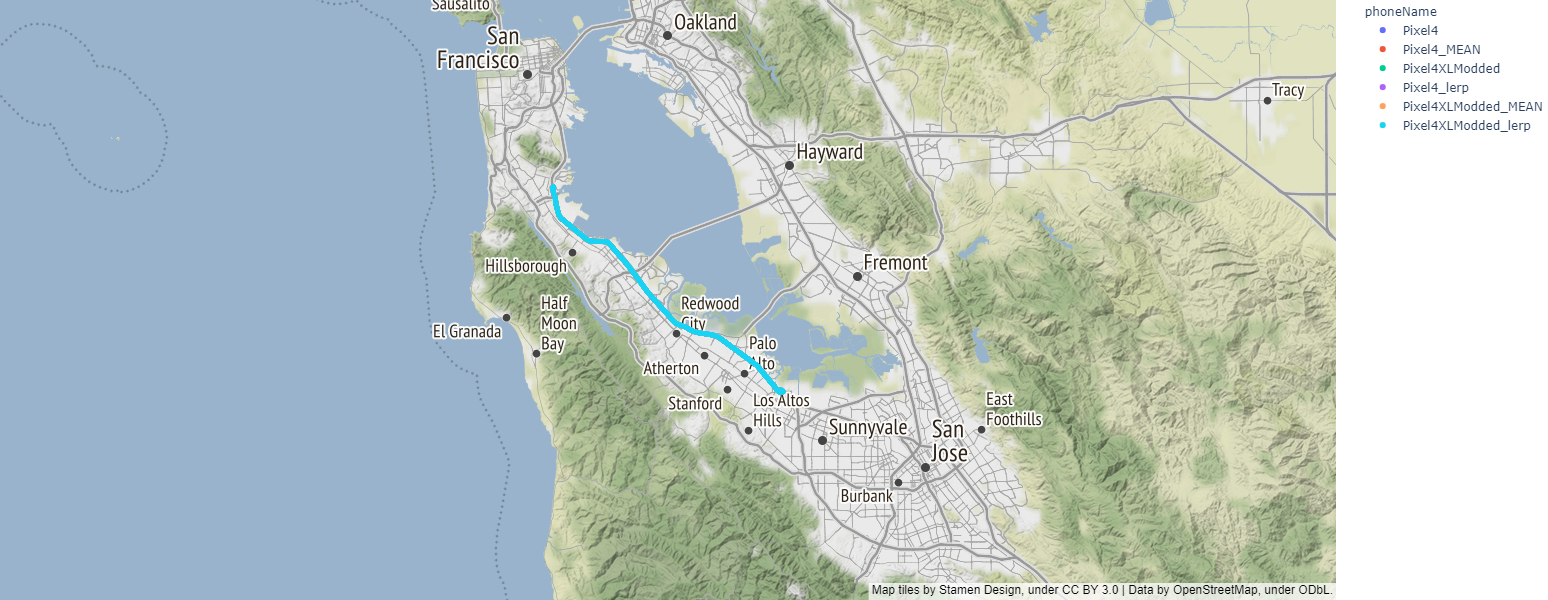

In [369]:
tmp3 = train_mean_pred.copy()
tmp3['phoneName'] = tmp3['phoneName'] + '_MEAN'

tmp = pd.concat([tmp1, tmp2, tmp3])
tmp = tmp.sort_values(['collectionName', 'millisSinceGpsEpoch']).reset_index(drop=True)
one_collection_viz(tmp, collections[0])

In [370]:
base_train['err'] = calc_haversine(ground_truth_train['latDeg'], ground_truth_train['lngDeg'], base_train['latDeg'], base_train['lngDeg'])
df_basepreds_kf['err'] = calc_haversine(ground_truth_train['latDeg'], ground_truth_train['lngDeg'], df_basepreds_kf['latDeg'], df_basepreds_kf['lngDeg'])
train_mean_pred['err'] = calc_haversine(ground_truth_train['latDeg'], ground_truth_train['lngDeg'], train_mean_pred['latDeg'], train_mean_pred['lngDeg'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [371]:
df_basepreds_kf['phone'] = df_basepreds_kf['collectionName'] + '_' + df_basepreds_kf['phoneName']
df_basepreds_kf_result = df_basepreds_kf.groupby('phone')['err'].agg([percentile50, percentile95])

df_basepreds_kf_result['p50_p90_mean'] = (df_basepreds_kf_result['percentile50'] + df_basepreds_kf_result['percentile95']) / 2 

df_basepreds_kf_score = df_basepreds_kf_result['p50_p90_mean'].mean()
df_basepreds_kf_score

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



4.5511221131190664

In [372]:
train_mean_pred['phone'] = train_mean_pred['collectionName'] + '_' + train_mean_pred['phoneName']
train_mean_pred_result = train_mean_pred.groupby('phone')['err'].agg([percentile50, percentile95])

train_mean_pred_result['p50_p90_mean'] = (train_mean_pred_result['percentile50'] + train_mean_pred_result['percentile95']) / 2 

train_mean_pred_score = train_mean_pred_result['p50_p90_mean'].mean()
train_mean_pred_score

4.117064134861156

## inference

In [373]:
# kalmanスムーザー
kf_smoothed_baseline = apply_kf_smoothing(base_test)

In [374]:
# 複数スマホで平均化
test_lerp = make_lerp_data(kf_smoothed_baseline)
test_mean_pred = calc_mean_pred(kf_smoothed_baseline, test_lerp)

In [375]:
test_mean_pred

collectionName        phoneName  millisSinceGpsEpoch  \
0      2020-05-15-US-MTV-1           Pixel4        1273608785432   
1      2020-05-15-US-MTV-1           Pixel4        1273608786432   
2      2020-05-15-US-MTV-1           Pixel4        1273608787432   
3      2020-05-15-US-MTV-1           Pixel4        1273608788432   
4      2020-05-15-US-MTV-1           Pixel4        1273608789432   
...                    ...              ...                  ...   
91481  2021-04-29-US-SJC-3  SamsungS20Ultra        1303763185000   
91482  2021-04-29-US-SJC-3  SamsungS20Ultra        1303763186000   
91483  2021-04-29-US-SJC-3  SamsungS20Ultra        1303763187000   
91484  2021-04-29-US-SJC-3  SamsungS20Ultra        1303763188000   
91485  2021-04-29-US-SJC-3  SamsungS20Ultra        1303763189000   

                  latDeg              lngDeg  
0      37.41661092075520 -122.08195871056743  
1      37.41662341259523 -122.08200865167863  
2      37.41662724685288 -122.08203999432641  
3      37.41662254767957 -122.08206015889044  
4      37.41662082690702 -122.08206954083521  
...                  ...                 ...  
91481  37.33454171510012 -121.89938939186558  
91482  37.33454356269756 -121.89938080819917  
91483  37.33454644808067 -121.89937269198464  
91484  37.33454972569288 -121.89936490779630  
91485  37.33455678271412 -121.89935538489084  

[91486 rows x 5 columns]

In [377]:
sample_sub['latDeg'] = test_mean_pred['latDeg']
sample_sub['lngDeg'] = test_mean_pred['lngDeg']
sample_sub.to_csv(OUTPUT + '/submission.csv', index=False)